# Check Loglikelihood model selection behaviour Bays09

1/3

We need to verify if the LL is correlated with the Mixture model summary stats fits. If they are not, something went wrong somewhere, or the parameters are interacting in a weird way that we need to understand...

Performed by *generator_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py*


In [253]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io
import scipy.stats.mstats as mstats 


from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [254]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [255]:
from plotly import offline as py
from plotly import graph_objs as go
py.init_notebook_mode(connected=True)


In [256]:
from IPython.html import widgets # Widget definitions
from IPython.display import display # Used to display widgets in the notebook
from IPython.html.widgets import interact
from plotly.widgets import GraphWidget 

In [260]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/
%run reloader_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015
Reloader data generated from  generator_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py
Running  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/reloader_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py
Arguments: []

        Reload outputs run with the automatic parameter generator for PBS

        Should handle random sampling of the parameter space.
    
Reloader data generated from  generator_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-01a2fcb0-0d7c-4c8f-b88c-15992f4a023f.npy
0.00%, -- left - 10.12 18:48
M 572.00, ratio_conj 0.34, sigmax 0.08, sigma_output 2.16
/

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-2375a39b-ef82-4fc8-88ca-ef265c858f31.npy
12.41%, 1s left - 10.12 18:48
M 261.00, ratio_conj 0.31, sigmax 0.03, sigma_output 2.94
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-23c6bc40-8f53-45c4-aef9-950d61a027c6.npy
12.59%, 1s left - 10.12 18:48
M 349.00, ratio_conj 0.83, sigmax 0.68, sigma_output 1.86
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays0

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-4355aa43-d505-4385-9735-f5547bce3c23.npy
24.82%, 1s left - 10.12 18:48
M 326.00, ratio_conj 0.44, sigmax 0.79, sigma_output 1.70
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-43b2aed0-518c-433f-a70a-4bf88ab57185.npy
25.00%, 1s left - 10.12 18:48
M 204.00, ratio_conj 0.08, sigmax 0.36, sigma_output 2.04
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays0

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-5f3108be-82e0-4b7e-8463-9611fd9554e8.npy
36.87%, 1s left - 10.12 18:48
M 232.00, ratio_conj 0.43, sigmax 0.48, sigma_output 0.26
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-604fcd20-2ce8-449a-9652-513b63c31b39.npy
37.05%, 1s left - 10.12 18:48
M 150.00, ratio_conj 0.96, sigmax 0.08, sigma_output 2.22
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays0

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-7eb6f16d-6f8f-4dd9-8a0c-1985350569fc.npy
48.38%, 1s left - 10.12 18:48
M 78.00, ratio_conj 0.46, sigmax 0.75, sigma_output 0.45
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-7ef1c9dc-6f73-44df-b046-41757e0009f2.npy
48.56%, 1s left - 10.12 18:48
M 541.00, ratio_conj 0.82, sigmax 0.68, sigma_output 1.41
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-a045cdc1-10f4-46d8-b4b1-2886946e62fc.npy
61.69%, 1s left - 10.12 18:48
M 416.00, ratio_conj 0.96, sigmax 0.23, sigma_output 1.08
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-a065d9c0-cf24-4400-a82a-f6e6c7b944d2.npy
61.87%, 1s left - 10.12 18:48
M 192.00, ratio_conj 0.33, sigmax 0.60, sigma_output 0.12
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays0

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-bf3e60ae-eec5-495f-9a3d-73bf5b27720e.npy
75.00%, 0s left - 10.12 18:48
M 539.00, ratio_conj 0.82, sigmax 0.63, sigma_output 1.61
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-bf84a466-0b78-40c1-a75a-25544939a397.npy
75.18%, 0s left - 10.12 18:48
M 37.00, ratio_conj 0.24, sigmax 0.49, sigma_output 0.17
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-de230674-6525-4656-88e3-725ec84b1a17.npy
88.13%, 0s left - 10.12 18:48
M 567.00, ratio_conj 0.40, sigmax 0.83, sigma_output 1.05
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-de362400-8332-4203-98b0-e4ee04dbd332.npy
88.31%, 0s left - 10.12 18:48
M 245.00, ratio_conj 0.33, sigmax 0.41, sigma_output 0.45
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays0

Result is not array, file looks bad: ./LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-d1c7a81a-6ab3-4479-9dff-4d7b5819ff15
result_ll_sum flat dimensions: 556 of (4, 3)
Found new results_shape: (4, 3)
Result is not array, file looks bad: ./LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-0b4e9228-c413-4fb8-974e-0c89169af36a
Result is not array, file looks bad: ./LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-1433aa77-8003-44d8-9d5f-fd835eb643a3
Result is not array, file looks bad: ./LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-28a161d1-ed6d-4338-893b-10044254f8da
Result is not array, file looks bad: ./LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_

In [262]:
#### SETUP
#
plots_bestfits = True
plots_scatter3d = False

savefigs = True

#
#### /SETUP

In [269]:
# Extract data
result_ll_sum_flat = np.array(data_pbs.dict_arrays['result_ll_sum']['results_flat'])
result_ll90_sum_flat = np.array(data_pbs.dict_arrays['result_ll90_sum']['results_flat'])
# result_ll_nn_flat = np.array(data_pbs.dict_arrays['result_ll_n']['results_flat'])
result_precision_flat = np.array(data_pbs.dict_arrays['result_precision']['results_flat'])
result_em_fits_flat = np.array(data_pbs.dict_arrays['result_em_fits']['results_flat'])
result_emfit_mse_flat = np.array(data_pbs.dict_arrays['result_emfit_mse']['results_flat'])
result_emfit_mixt_kl_flat = np.array(data_pbs.dict_arrays['result_emfit_mixt_kl']['results_flat'])
result_fi_theo_flat = np.array(data_pbs.dict_arrays['result_fi_theo']['results_flat'])
result_fi_theocov_flat = np.array(data_pbs.dict_arrays['result_fi_theocov']['results_flat'])

result_parameters_flat = np.array(data_pbs.dict_arrays['result_ll_sum']['parameters_flat'])
all_repeats_completed = data_pbs.dict_arrays['result_ll_sum']['repeats_completed']

all_args_arr = np.array(data_pbs.loaded_data['args_list'])

M_space = data_pbs.loaded_data['parameters_uniques']['M']
ratio_conj_space = data_pbs.loaded_data['parameters_uniques']['ratio_conj']
sigmax_space = data_pbs.loaded_data['parameters_uniques']['sigmax']
sigmaoutput_space = data_pbs.loaded_data['parameters_uniques']['sigma_output']

num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']

In [270]:
def str_best_params(best_i, result_dist_to_use):
    return '[{:3d}] '.format(best_ind) + ' '.join(["%s %.4f" % (parameter_names_sorted[param_i], result_parameters_flat[best_i, param_i]) 
                     for param_i in xrange(len(parameter_names_sorted))]) + ' >> %f' % result_dist_to_use[best_i]


In [271]:
# Reload experimental data
experiment_id = all_args_arr[0]['experiment_id']
data_groundtruth = load_experimental_data.load_data(experiment_id=experiment_id)
T_space = data_groundtruth['data_to_fit']['n_items']

reloaded mixture model from cache /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data/Bays2009/em_bays_basicmodel.pickle
reloaded collapsed mixture model from cache /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data/Bays2009/collapsed_em_bays_new.pickle


In [272]:
## Filter everything with repeats_completed == num_repet
filter_data = all_repeats_completed == num_repetitions - 1

result_parameters_flat = result_parameters_flat[filter_data]
all_args_arr = all_args_arr[filter_data]
all_repeats_completed = all_repeats_completed[filter_data]

print "Size post-filter: ", result_parameters_flat.shape[0]


Size post-filter:  543


In [276]:
# Compute lots of averages over the repetitions
result_ll_sum_avg = utils.nanmean(result_ll_sum_flat, axis=-1)
result_ll90_sum_avg = utils.nanmean(result_ll90_sum_flat, axis=-1)
result_em_fits_avg = utils.nanmean(result_em_fits_flat, axis=-1)
result_emfit_mse_avg = utils.nanmean(result_emfit_mse_flat, axis=-1)
result_emfit_mixt_kl_avg = utils.nanmean(result_emfit_mixt_kl_flat, axis=-1)
# result_ll_nn_avg = utils.nanmean(result_ll_nn_flat, axis=-1)

# Compute best results
result_dist_emfit_mse = np.nansum(np.nansum(result_emfit_mse_avg, axis=-1), axis=-1)
result_dist_emfit_kl = np.nansum(result_emfit_mixt_kl_avg, axis=-1)
result_dist_nll = np.nansum(-result_ll_sum_avg, axis=-1)
result_dist_nll90 = np.nansum(-result_ll90_sum_avg, axis=-1)

# Get the best fitting parameters
best_params_em = np.argsort(result_dist_emfit_mse)
best_params_kl = np.argsort(result_dist_emfit_kl)
best_params_ll = np.argsort(result_dist_nll)
best_params_ll90 = np.argsort(result_dist_nll90)

result_ll_sum_renormall = (result_ll_sum_avg - result_ll_sum_avg.min()) + 0.01
result_ll_sum_renormeach = (result_ll_sum_avg - result_ll_sum_avg.min(axis=0)) + 0.01
result_dist_nllnormall_sum = np.nansum(-result_ll_sum_renormall, axis=-1)
result_dist_nllnormall_prod = -np.prod(result_ll_sum_renormall, axis=-1)
result_dist_nllnormall_geom = -mstats.gmean(result_ll_sum_renormall, axis=-1)
# result_dist_nllnormeach_sum = -np.nansum(result_ll_sum_renormeach, axis=-1)
# result_dist_nllnormeach_prod = -np.prod(result_ll_sum_renormeach, axis=-1)
# result_dist_ll_median_avg = -np.median(result_ll_nn_flat.reshape(result_ll_nn_avg.shape[0], -1), axis=-1)

result_dist_nllnormall_prod = (result_dist_nllnormall_prod - result_dist_nllnormall_prod.min()) + 0.01
result_dist_nllnormall_geom = (result_dist_nllnormall_geom - result_dist_nllnormall_geom.min()) + 0.01

## -> Pandas now

In [277]:
df_all_fits = pd.DataFrame.from_items([('M', result_parameters_flat[:, 0]),
                                       ('ratio_conj', result_parameters_flat[:, 1]),
                                       ('sigmax', result_parameters_flat[:, 2]),
                                       ('sigma_output', result_parameters_flat[:, 3]),
                                       ('dist_emfit_mse', result_dist_emfit_mse),
                                       ('dist_emfit_kl', result_dist_emfit_kl),
                                       ('dist_nll', result_dist_nll),
                                       ('dist_nll90', result_dist_nll90),
                                       ('dist_nllnormall_sum', result_dist_nllnormall_sum),
                                       ('dist_nllnormall_prod', result_dist_nllnormall_prod),
                                       ('dist_nllnormall_geom', result_dist_nllnormall_geom),
#                                        ('dist_ll_median', result_dist_ll_median_avg),
                                      ])
df_all_fits = df_all_fits.assign(dist_emfit_mse_log = lambda x: np.log(x['dist_emfit_mse']),
                                 dist_nll_log = lambda x: np.log(x['dist_nll']),
                                 dist_nll90_log = lambda x: np.log(x['dist_nll90']),
                                 dist_nllnormall_prod_log = lambda x: np.log(x['dist_nllnormall_prod'])
                                )

In [278]:
# Filter rows where LL > cutoff value
# LL_min_cutoff = 3500
# LL_min_cutoff = 3000
# df_best_fits = df_all_fits[df_all_fits.dist_nll < LL_min_cutoff]

# Good bounds
# LL_max_cutoff = 5000
# LL_min_cutoff = -1500
# sigma_output_cutoff = 0.4
# sigmax_min_cutoff = 0.05

# Bad bounds
LL_max_cutoff = 3000
LL_min_cutoff = -1000
sigma_output_cutoff = 0.5
sigmax_min_cutoff = 0.06


df_best_fits = df_all_fits[df_all_fits.dist_nll < LL_max_cutoff]
df_best_fits = df_best_fits[df_best_fits.dist_nll > LL_min_cutoff]
df_best_fits = df_best_fits[df_best_fits.sigma_output < sigma_output_cutoff]
df_best_fits = df_best_fits[df_best_fits.sigmax > sigmax_min_cutoff]

In [279]:
## Correlations
df_best_fits.corr()

,M,ratio_conj,sigmax,sigma_output,dist_emfit_mse,dist_emfit_kl,dist_nll,dist_nll90,dist_nllnormall_sum,dist_nllnormall_prod,dist_nllnormall_geom,dist_emfit_mse_log,dist_nll90_log,dist_nll_log,dist_nllnormall_prod_log
M,1.000000,0.360558,0.150257,0.170049,-0.056264,0.043500,-0.004898,-0.261796,-0.004898,0.012039,0.011762,-0.063493,-0.265964,-0.003941,0.021184
ratio_conj,0.360558,1.000000,0.171239,-0.078273,0.142849,-0.074137,-0.290031,-0.366701,-0.290031,-0.297450,-0.296973,0.007923,-0.368011,-0.292119,-0.168387
sigmax,0.150257,0.171239,1.000000,-0.233364,0.083680,-0.244552,0.617725,0.687207,0.617725,0.589546,0.591623,0.087093,0.686070,0.609444,0.206679
sigma_output,0.170049,-0.078273,-0.233364,1.000000,0.710928,0.263800,-0.347248,-0.069713,-0.347248,-0.355963,-0.356014,0.680046,-0.091978,-0.347663,-0.129487
dist_emfit_mse,-0.056264,0.142849,0.083680,0.710928,1.000000,0.107409,-0.174786,0.194062,-0.174786,-0.201785,-0.202001,0.917433,0.187969,-0.175035,-0.046634
dist_emfit_kl,0.043500,-0.074137,-0.244552,0.263800,0.107409,1.000000,0.170592,0.049928,0.170592,0.184648,0.184195,0.200458,0.009473,0.172090,0.128976
dist_nll,-0.004898,-0.290031,0.617725,-0.347248,-0.174786,0.170592,1.000000,0.826139,1.000000,0.998306,0.998688,-0.154414,0.819386,0.998701,0.429051
dist_nll90,-0.261796,-0.366701,0.687207,-0.069713,0.194062,0.049928,0.826139,1.000000,0.826139,0.799664,0.800776,0.218552,0.995793,0.821653,0.351050
dist_nllnormall_sum,-0.004898,-0.290031,0.617725,-0.347248,-0.174786,0.170592,1.000000,0.826139,1.000000,0.998306,0.998688,-0.154414,0.819386,0.998701,0.429051
dist_nllnormall_prod,0.012039,-0.297450,0.589546,-0.355963,-0.201785,0.184648,0.998306,0.799664,0.998306,1.000000,0.999871,-0.179352,0.794129,0.998733,0.439962


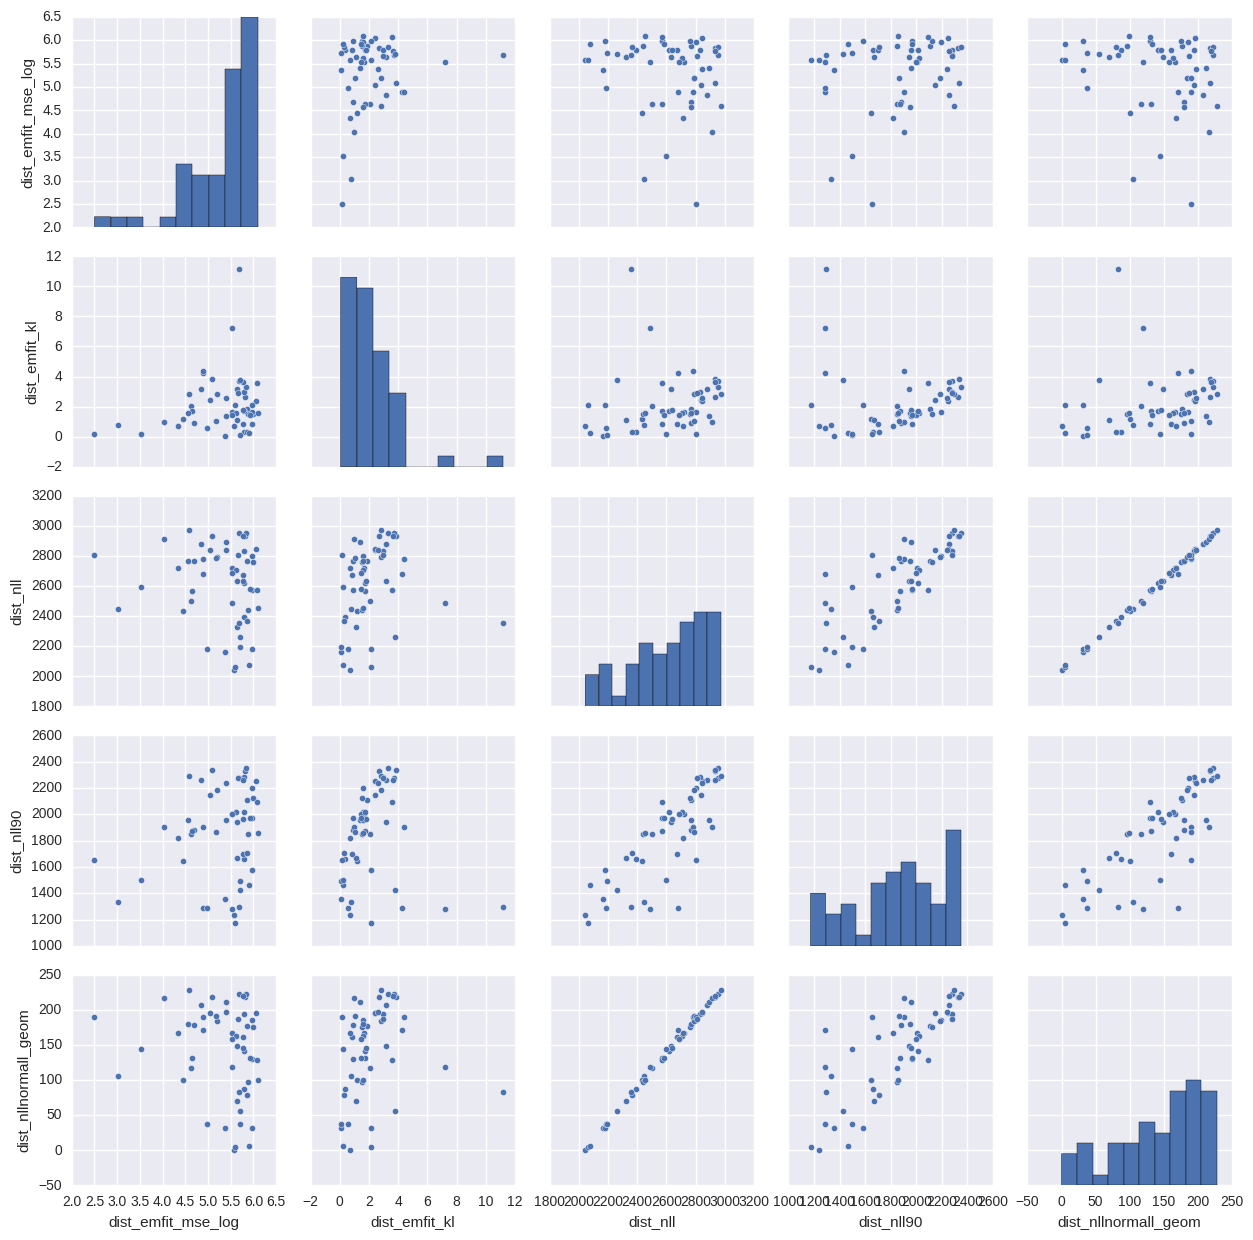

In [280]:
# Cross-correlation plots
sns.pairplot(df_best_fits,
             vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_nll', 'dist_nll90', 'dist_nllnormall_geom'],
            )

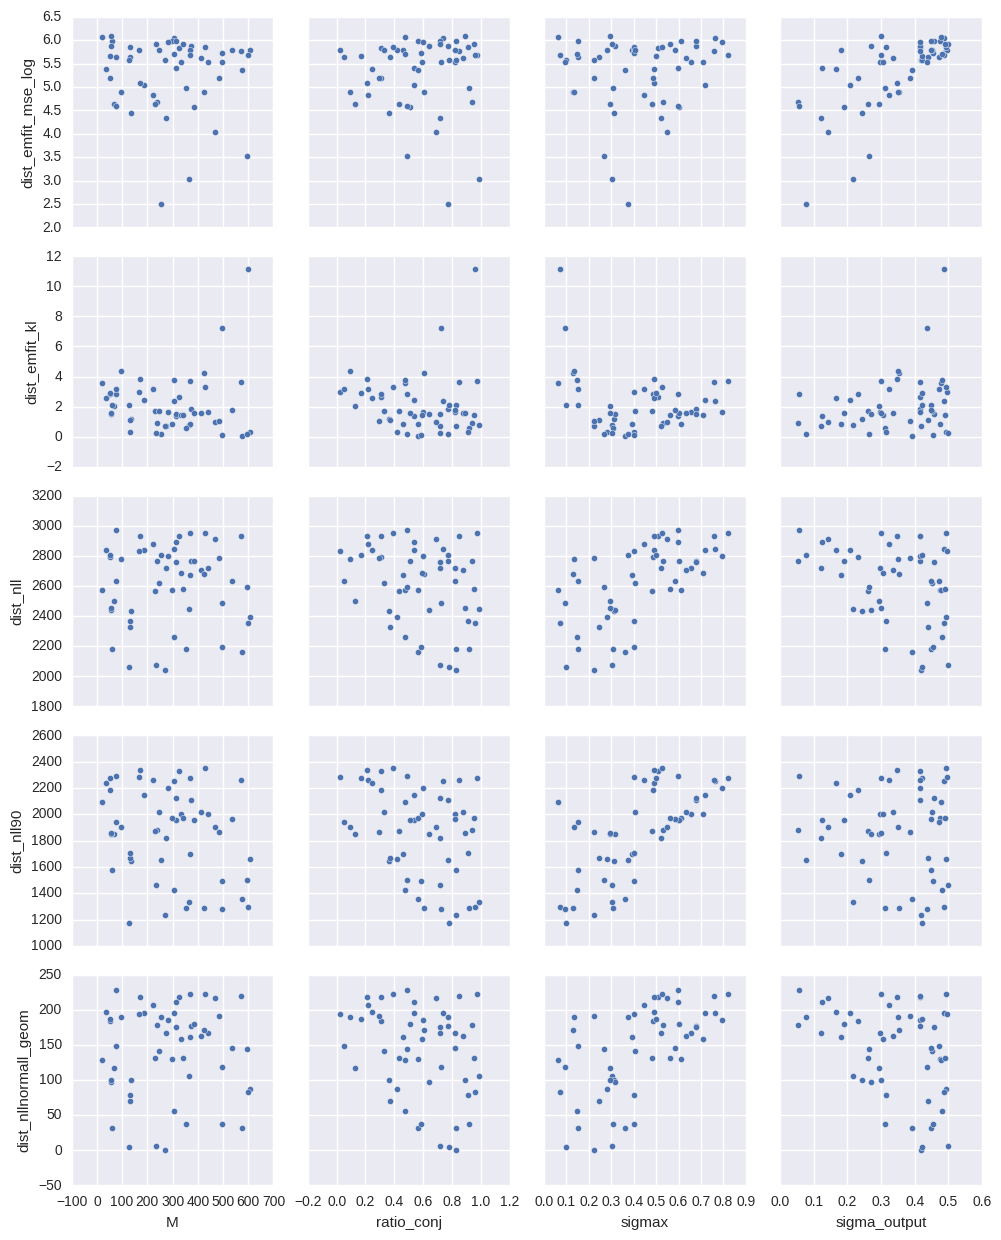

In [281]:
# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=['M', 'ratio_conj', 'sigmax', 'sigma_output'],
             y_vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_nll', 'dist_nll90', 'dist_nllnormall_geom']
            )

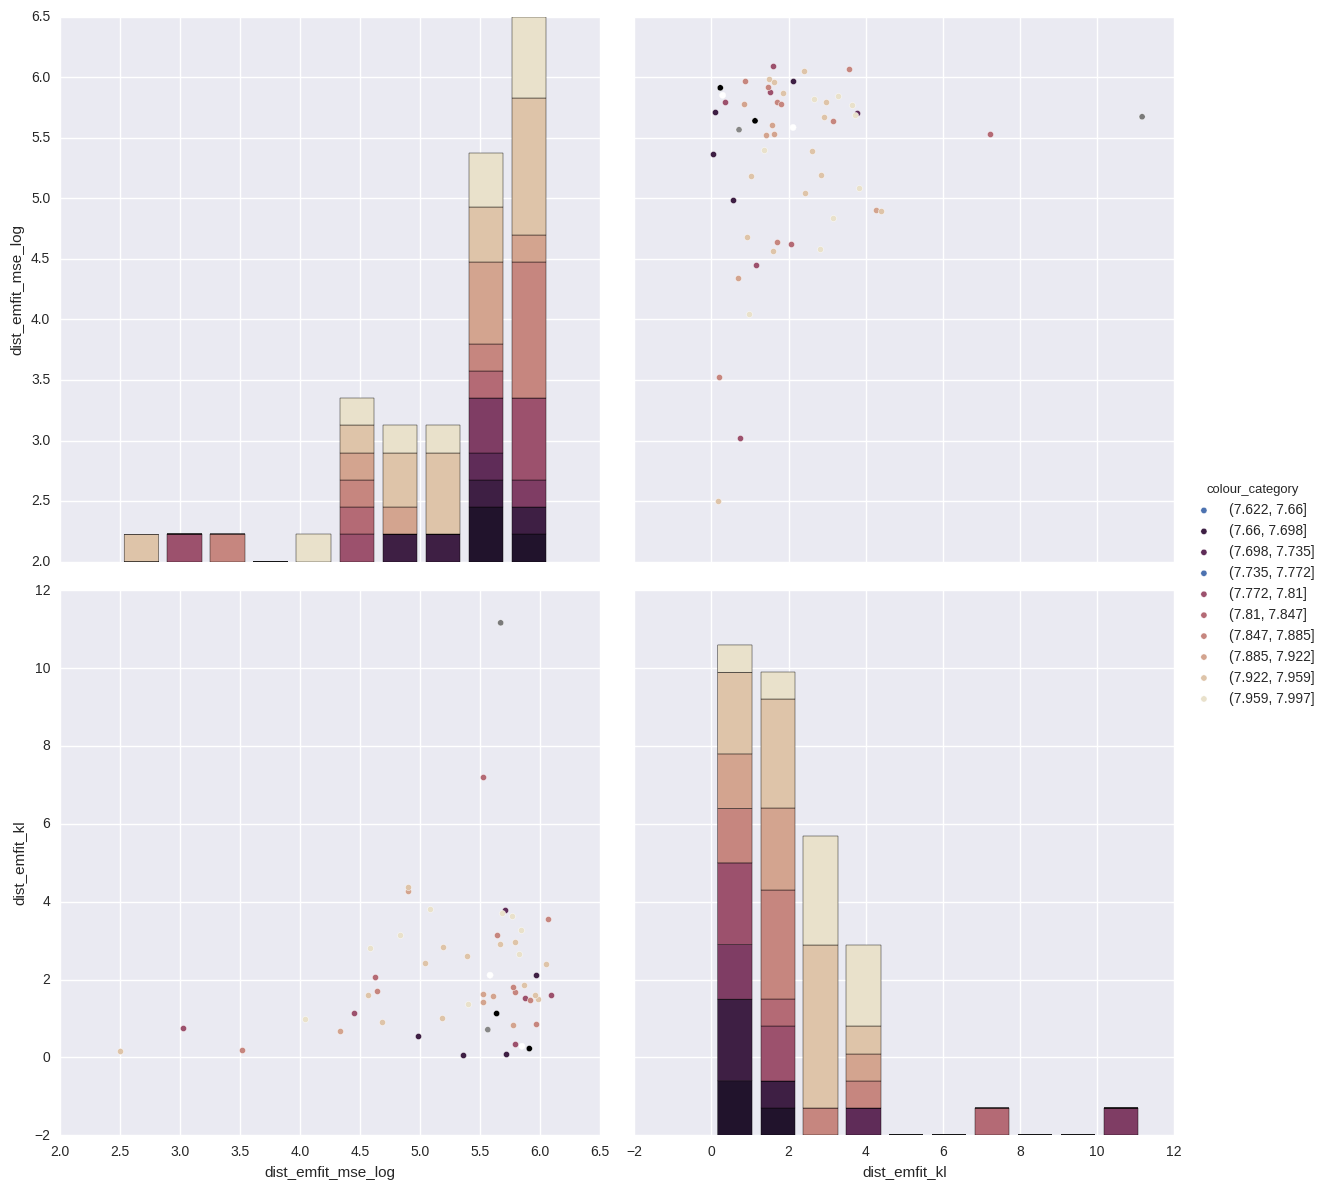

In [282]:
# Color code for Colour KL fit this time 
mycubehelix = sns.cubehelix_palette(dark=0.15, n_colors=10, start=0, rot=0.5, gamma=1.2, hue=0.9, light=0.9, reverse=True)
sns.pairplot(df_best_fits.assign(colour_category=pd.cut(np.log(df_best_fits['dist_nll']), bins=10)),
             hue='colour_category',
             palette=mycubehelix,
             vars=['dist_emfit_mse_log', 'dist_emfit_kl'],
             size = 6
            )

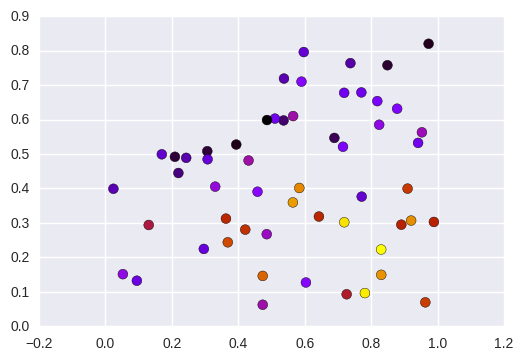

In [283]:
plt.scatter(df_best_fits.ratio_conj, df_best_fits.sigmax, c=np.log(df_best_fits.dist_nll), cmap='gnuplot_r', s=50)

## Plotly Scatter3d

In [247]:
params = ['M', 'ratio_conj', 'sigmax']
result_to_color = np.array(df_best_fits['dist_nll'])
result_to_color = np.log(result_to_color)

params = ['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_nll90_log']
result_to_color = np.array(df_best_fits['dist_nll90_log'])


text = ['> %s' % (x) for x in result_to_color]

trace1 = go.Scatter3d(
        x = df_best_fits[params[0]],
        y = df_best_fits[params[1]],
        z = df_best_fits[params[2]],
        text = text,
        mode = 'markers',
        marker = go.Marker(
            color = result_to_color,
            size = 8,
            colorscale='Viridis',
            opacity=0.7
        )
    )
data = [trace1]
layout = go.Layout(
    title='Landscape for NLL',
    autosize=False,
    width=700,
    height=700,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0),
    scene=go.Scene(
        xaxis=go.XAxis(
            title=params[0],
        ),
        yaxis=go.YAxis(
            title=params[1],
        ),
        zaxis=go.ZAxis(
            title=params[2],
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Look at best parameters


In [239]:
max_best_params = 10
print 'EM MSE'
print '\n'.join([str_best_params(best_ind, result_dist_emfit_mse) for best_ind in best_params_em[:max_best_params]])

print
print 'EM KL'
print '\n'.join([str_best_params(best_ind, result_dist_emfit_kl) for best_ind in best_params_kl[:max_best_params]])

print
print 'LL'
print '\n'.join([str_best_params(best_ind, result_dist_nll) for best_ind in best_params_ll[:max_best_params]])

print
print 'LL90'
print '\n'.join([str_best_params(best_ind, result_dist_nll90) for best_ind in best_params_ll90[:max_best_params]])

EM MSE
[435] M 254.0000 ratio_conj 0.7717 sigmax 0.3764 sigma_output 0.0754 >> 12.178680
[ 52] M 365.0000 ratio_conj 0.9890 sigmax 0.3029 sigma_output 0.2151 >> 20.586848
[530] M 595.0000 ratio_conj 0.4857 sigmax 0.2674 sigma_output 0.2632 >> 33.812636
[394] M 470.0000 ratio_conj 0.6894 sigmax 0.5468 sigma_output 0.1425 >> 56.983587
[ 54] M 528.0000 ratio_conj 0.9167 sigmax 0.6391 sigma_output 0.0665 >> 62.650339
[282] M 274.0000 ratio_conj 0.7153 sigmax 0.5212 sigma_output 0.1206 >> 76.601981
[361] M 433.0000 ratio_conj 0.8337 sigmax 0.7153 sigma_output 0.0428 >> 85.104631
[ 81] M 135.0000 ratio_conj 0.3630 sigmax 0.3125 sigma_output 0.2427 >> 85.504491
[323] M 384.0000 ratio_conj 0.5104 sigmax 0.6029 sigma_output 0.1889 >> 96.077465
[154] M 290.0000 ratio_conj 0.0552 sigmax 0.4968 sigma_output 0.2523 >> 96.113512

EM KL
[145] M 574.0000 ratio_conj 0.5645 sigmax 0.3596 sigma_output 0.3931 >> 0.051791
[464] M 495.0000 ratio_conj 0.5838 sigmax 0.4015 sigma_output 0.4558 >> 0.095731
[435

THIS IS FITTED ON FULL DATA, NOT ONLY ON 500 FIRST SAMPLES AS OUR MODEL


UnboundLocalError: local variable 'f1' referenced before assignment

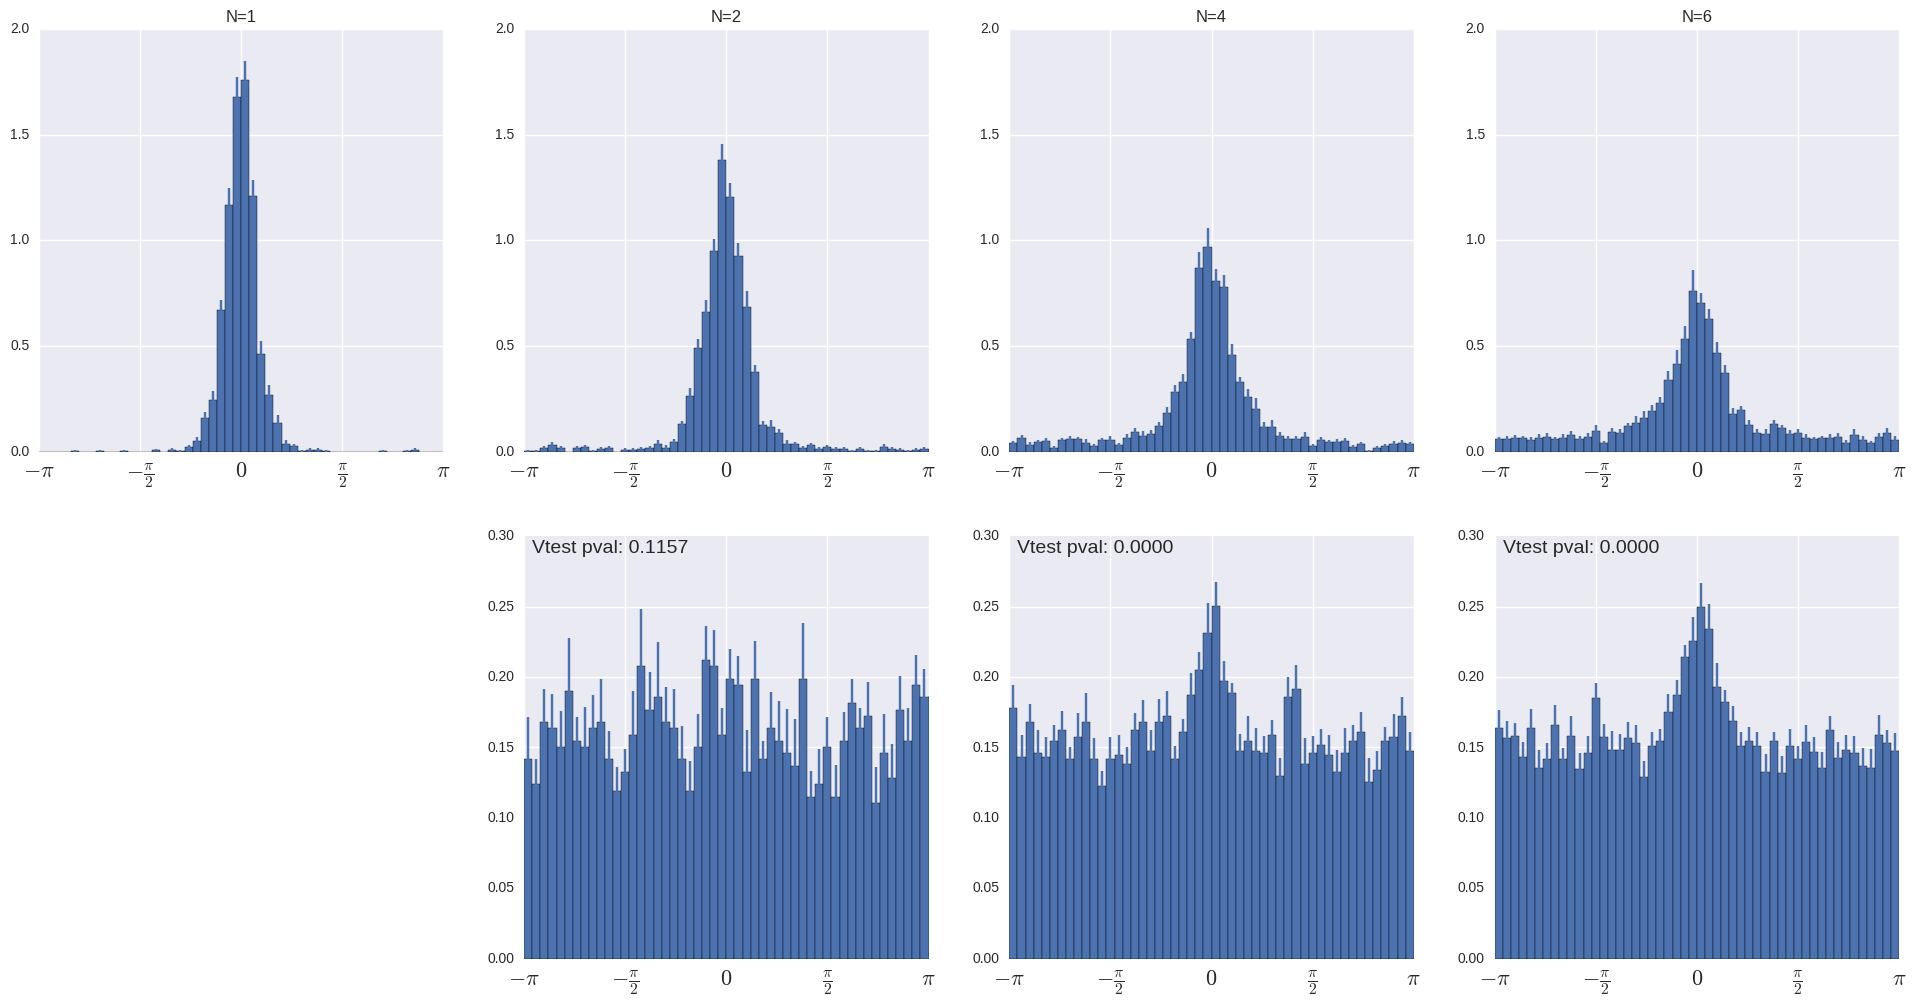

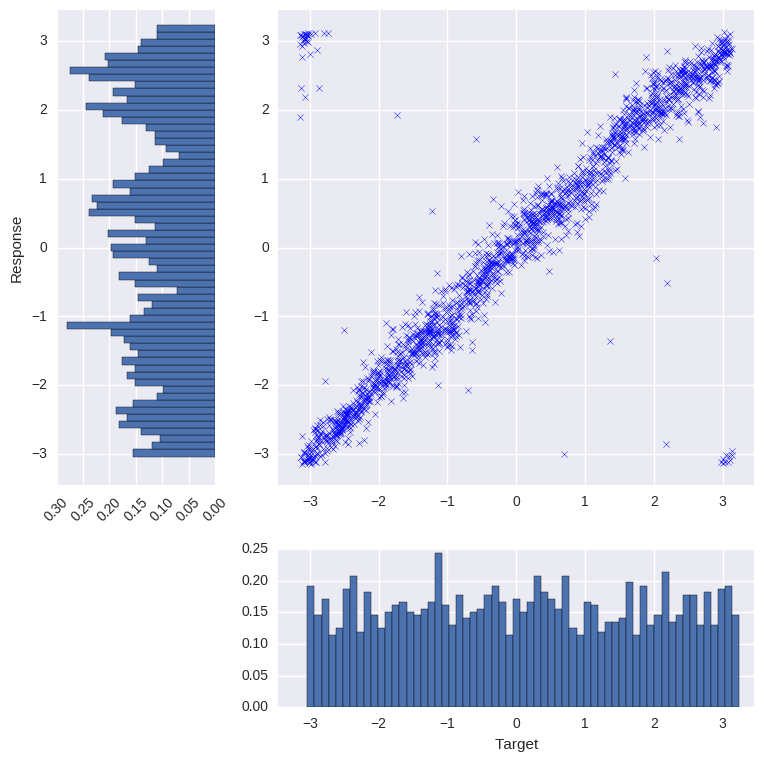

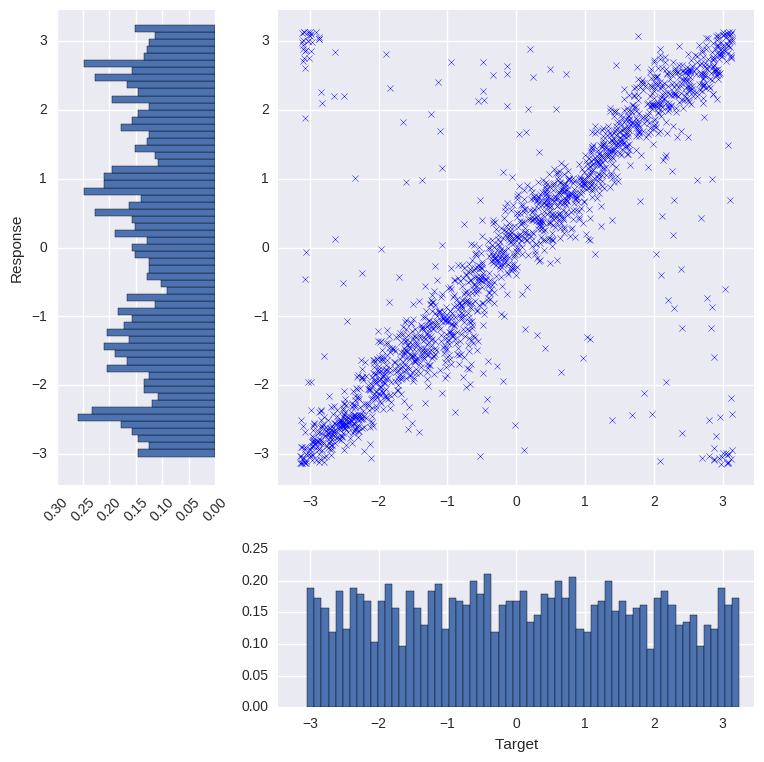

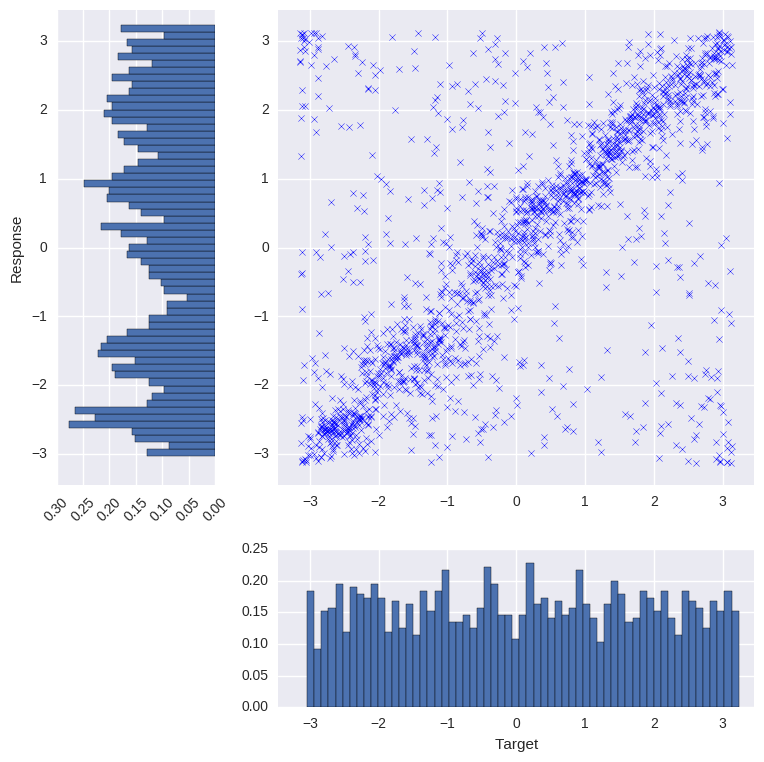

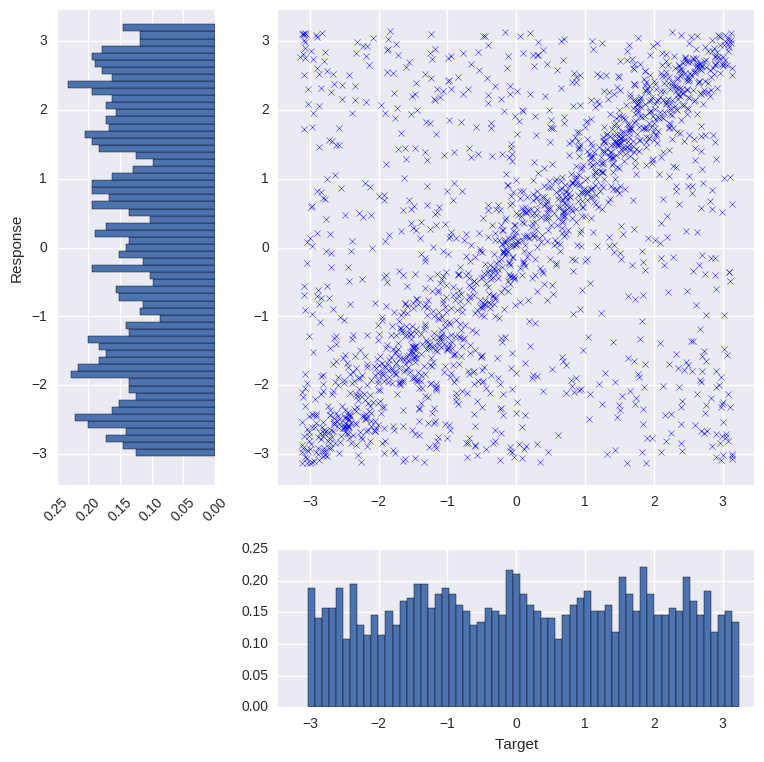

In [240]:
# Ground truth
print 'THIS IS FITTED ON FULL DATA, NOT ONLY ON 500 FIRST SAMPLES AS OUR MODEL'

plots_experimental_data.plots_bays2009(data_groundtruth)

In [50]:
# Plot best
def plot_modelfits(T_space, curr_result_emfits_t, labelplot='', dataio=None):
    curr_result_avg = np.mean(curr_result_emfits_t, axis=-1)
    curr_result_std = np.std(curr_result_emfits_t, axis=-1)
    
    f, ax = plt.subplots()    
    ax = plots_experimental_data.plot_kappa_mean_error(T_space, curr_result_avg[..., 0], curr_result_std[..., 0], title=labelplot, ax=ax, label='Kappa', xlabel='Number of items')

    if dataio is not None:
        dataio.save_current_figure('bestfit_%s_kappa_{label}_{unique_id}.pdf' % labelplot)

    f, ax = plt.subplots()
    ax = plots_experimental_data.plot_emmixture_mean_error(T_space, curr_result_avg[..., 1], curr_result_std[..., 1], title=labelplot, label='Target', ax=ax)
    ax = plots_experimental_data.plot_emmixture_mean_error(T_space, curr_result_avg[..., 2], curr_result_std[..., 2], title=labelplot, label='Nontarget', ax=ax)
    ax = plots_experimental_data.plot_emmixture_mean_error(T_space, curr_result_avg[..., 3], curr_result_std[..., 3], title=labelplot, label='Random', ax=ax)
    
    if dataio is not None:
        dataio.save_current_figure('bestfit_%s_mixttarget_{label}_{unique_id}.pdf' % labelplot)

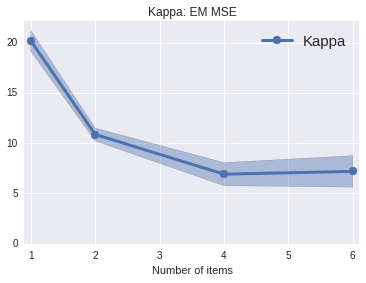

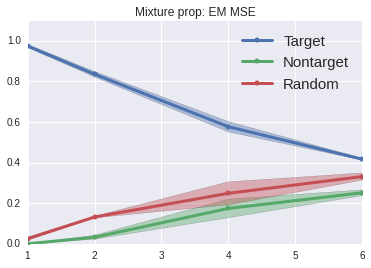

In [51]:
# Best fit for EM MSE
@interact(best_index=(0, 10, 1))
def plot_model_fit(best_index=0):
    plot_modelfits(T_space, result_em_fits_flat[best_params_em[best_index]], 'EM MSE')

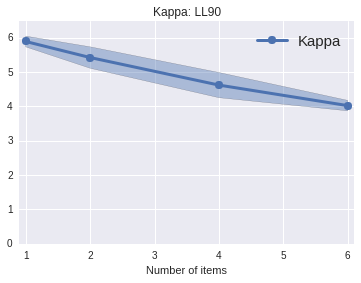

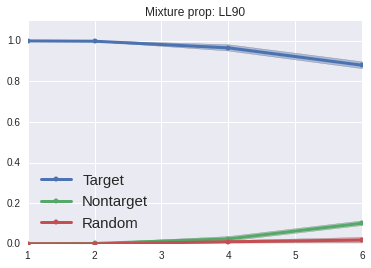

In [52]:
# Best fit for LL90
@interact(best_index=(0, 10, 1))
def plot_model_fit(best_index=0):
    plot_modelfits(T_space, result_em_fits_flat[best_params_ll90[best_index]], 'LL90')

# Observations

I think that the LL requires too high Sigma_output in order to get likely samples.
This corresponds to what I saw before, most points are too unlikely with a very flat sampling posterior, and sigma_output alleviates that.

It's flagrant with the correlation between sigma_output and emfit_MSE, where having sigma_output too high will destroy the fit of Kappas.

Hence we really need to move to another likelihood function, not with sigma_output, but with a baseline lapse rate. This should provide a small amount of support everywhere, without interacting with kappa at all.
Let's hope that will work.

It's unclear if starting CMA/ES runs will be useful or not.

# Updating to new FitExperiment codebase

In [252]:
df_bestparams_nll = df_best_fits.sort_values(by='dist_emfit_kl', ascending=True).head(10).median()
df_bestparams_nll

M                           3.130000e+02
ratio_conj                  7.172387e-01
sigmax                      3.332712e-01
sigma_output                3.545591e-01
dist_emfit_mse              2.375402e+02
dist_emfit_kl               2.591212e-01
dist_nll                    2.280569e+03
dist_nll90                  1.496710e+03
dist_nllnormall_sum        -2.359044e+04
dist_nllnormall_prod        4.841201e+13
dist_nllnormall_geom        5.843199e+01
dist_emfit_mse_log          5.465192e+00
dist_nll90_log              7.311024e+00
dist_nll_log                7.731475e+00
dist_nllnormall_prod_log    3.144504e+01
dtype: float64

In [27]:
# Check best parameters
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_allmetrics',
                             inference_method='none',
                             experiment_id='bays09',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=100,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=50,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             filter_datapoints_size=100, 
                             filter_datapoints_selection='random'
                             )

experiment_parameters.update(df_bestparams_nll)
for key in ['M']:
    experiment_parameters[key] = int(experiment_parameters[key])

with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    fit_exp = experiment_launcher.all_vars['fit_exp']
    results = experiment_launcher.all_vars['all_outputs_data']
    plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)
        

In [28]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=3, use_cache=True)
    axesFig6Fig13[0].figure.set_size_inches((5, 10))

Traceback (most recent call last):
  File "/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1118, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 300, in wrapped
    return f(*args, **kwargs)
  File "/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 345, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/inspect.py", line 1048, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/inspect.py", line 1008, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/nfs/nhome/live/lmatth

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



IndexError: string index out of range

In [44]:
def remove_outliers(df, n_stddev=5):
    outliers = np.sum(np.abs(spst.zscore(df)) < n_stddev, axis=-1)
    return df[outliers >= outliers.max()]

def df_add_quantize_parameters(df, parameters, nQuantiles):
    param_qbins = dict()
    param_qbins_middle = dict()

    for param_name in parameters:
        param_factored, param_qbins[param_name] = pd.qcut(df[param_name], nQuantiles, retbins=True, labels=False)
        param_qbins_middle[param_name] = ((param_qbins[param_name][:-1] + param_qbins[param_name][1:])/2.
                                         ).astype(df[param_name].dtype)
        df.loc[:, (param_name + "_qi")] = param_factored
    
    return df, param_qbins, param_qbins_middle

def filter_dataframe(df, parameters_values):
    filter_mask = None
    for key, value in parameters_values.iteritems():
        new_filter = (df[key] == value)
        if filter_mask is None:
            filter_mask = new_filter
        else:
            filter_mask = filter_mask & new_filter
    
    if filter_mask is None:
        return df
    else:
        return df[filter_mask]

def filter_quantized_param(df, target_parameters, param_qbins):
    quantized_parameters_targets = dict()
    
    for key, value in target_parameters.iteritems():
        target_qi = (np.digitize(value, param_qbins[key], right=False).item() - 1)
        quantized_parameters_targets[key + "_qi"] = target_qi

    return filter_dataframe(df, quantized_parameters_targets)



In [56]:
nQuantiles = 50
parameters = ['M', 'ratio_conj', 'sigmax', 'sigma_output']

df_quantized, param_qbins, param_qbins_middle = df_add_quantize_parameters(df_all_fits, parameters, nQuantiles)